**SMS CLASSIFICATION**

In [ ]:
import pandas as pd
dataset = pd.read_csv("dataset_sms_spam_v2.csv")
dataset


,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,promo
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,promo
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",promo
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",promo
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,promo
...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",normal
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,normal
1140,Mba mau kirim 300 ya,normal
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,normal


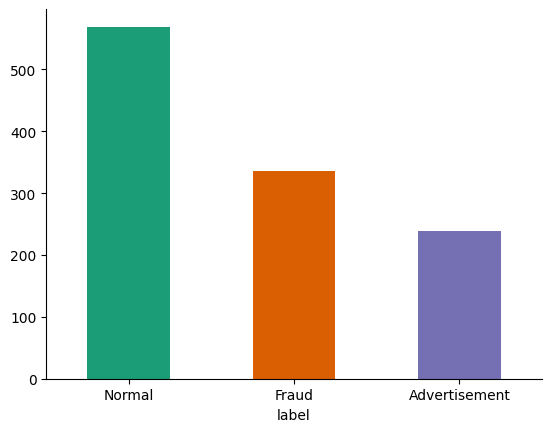

In [ ]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
# dataset.groupby('label').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
# plt.gca().spines[['top', 'right',]].set_visible(False)
ax = dataset.groupby('label').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))

# Changing the x-axis labels
ax.set_xticklabels(['Normal', 'Fraud', 'Advertisement'], rotation=0)

# Hide the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Show the updated plot
plt.show()

**Distribution of each label**

In [ ]:
print(dataset['label'].value_counts())

label
normal      569
penipuan    335
promo       239
Name: count, dtype: int64


In [ ]:
print(dataset.columns)

Index(['Teks', 'label'], dtype='object')


**PRE-PROCESSING SMS**

1. LowerCase SMS

In [ ]:
dataset['Teks'] = dataset['Teks'].str.lower()

2. Word Tokenization

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
dataset['tokens'] = dataset['Teks'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset['Teks'])

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token if used

print(f'Vocabulary Size: {vocab_size}')

Vocabulary Size: 5030


In [ ]:
dataset.head()

,Teks,label,tokens
0,[promo] beli paket flash mulai 1gb di my telko...,promo,"[[, promo, ], beli, paket, flash, mulai, 1gb, ..."
1,2.5 gb/30 hari hanya rp 35 ribu spesial buat a...,promo,"[2.5, gb/30, hari, hanya, rp, 35, ribu, spesia..."
2,"2016-07-08 11:47:11.plg yth, sisa kuota flash ...",promo,"[2016-07-08, 11:47:11.plg, yth, ,, sisa, kuota..."
3,"2016-08-07 11:29:47.plg yth, sisa kuota flash ...",promo,"[2016-08-07, 11:29:47.plg, yth, ,, sisa, kuota..."
4,4.5gb/30 hari hanya rp 55 ribu spesial buat an...,promo,"[4.5gb/30, hari, hanya, rp, 55, ribu, spesial,..."


In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from gensim.models import Word2Vec

# tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['Teks'])

# # Word Embeddings (Word2Vec)
# word2vec_model = Word2Vec([msg.split() for msg in dataset['Teks']], min_count=1)

# # Combine TF-IDF and Word Embeddings
# sms_embeddings = []
# for msg in dataset['Teks']:
#     msg_vector = np.zeros(word2vec_model.vector_size)
#     words = msg.split()
#     for word in words:
#         if word in word2vec_model.wv.key_to_index and word in tfidf_vectorizer.vocabulary_:  # Check if word exists in vocabulary
#             word_vector = word2vec_model.wv[word]
#             tfidf_score = tfidf_matrix[dataset[dataset['Teks'] == msg].index[0], tfidf_vectorizer.vocabulary_[word]]
#             weighted_word_vector = word_vector * tfidf_score
#             msg_vector += weighted_word_vector
#     sms_embeddings.append(msg_vector)

# # Add the embeddings as a new column in the DataFrame
# dataset['embeddings'] = sms_embeddings

from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
model = AutoModel.from_pretrained('indobenchmark/indobert-base-p2')

# Define a function to tokenize and get embeddings
def get_bert_embeddings(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    #print(inputs)
    # Get the embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the embeddings from the last hidden state
    embeddings = outputs.last_hidden_state

    # Average the token embeddings to get a single embedding vector for the text
    embeddings = embeddings.mean(dim=1)

    return embeddings.squeeze().numpy()

dataset['embeddings'] = dataset['Teks'].apply(get_bert_embeddings)
dataset.head()

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,Teks,label,tokens,embeddings
0,[promo] beli paket flash mulai 1gb di my telko...,promo,"[[, promo, ], beli, paket, flash, mulai, 1gb, ...","[0.070020966, -0.011666047, 0.21452843, 0.2642..."
1,2.5 gb/30 hari hanya rp 35 ribu spesial buat a...,promo,"[2.5, gb/30, hari, hanya, rp, 35, ribu, spesia...","[-0.0817389, 0.5771126, 0.27214924, -0.1896326..."
2,"2016-07-08 11:47:11.plg yth, sisa kuota flash ...",promo,"[2016-07-08, 11:47:11.plg, yth, ,, sisa, kuota...","[-0.2873105, 0.471666, 0.042700317, -0.0007432..."
3,"2016-08-07 11:29:47.plg yth, sisa kuota flash ...",promo,"[2016-08-07, 11:29:47.plg, yth, ,, sisa, kuota...","[-0.30691013, 0.31882998, -0.049610622, 0.0335..."
4,4.5gb/30 hari hanya rp 55 ribu spesial buat an...,promo,"[4.5gb/30, hari, hanya, rp, 55, ribu, spesial,...","[-0.27191436, 0.77962005, 0.24885651, -0.13167..."


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Encode the labels
dataset['label_encoded'] = label_encoder.fit_transform(dataset['label'])

In [ ]:
X = dataset['embeddings']
y = dataset['label_encoded']

import numpy as np

# Convert each list of embeddings into a numpy array
X = np.array([np.array(embedding) for embedding in X])
X


array([[ 0.07002097, -0.01166605,  0.21452843, ...,  0.96580774,
        -0.55518705,  0.18037014],
       [-0.0817389 ,  0.5771126 ,  0.27214924, ...,  0.8044826 ,
        -0.25427428,  1.0613095 ],
       [-0.2873105 ,  0.471666  ,  0.04270032, ...,  1.052653  ,
         0.07319905,  0.43162394],
       ...,
       [ 0.9458457 ,  1.2648375 ,  1.2664884 , ..., -0.01922341,
        -1.8549274 ,  1.26651   ],
       [ 0.7380026 ,  0.63959634,  0.01100346, ...,  0.72464955,
        -0.92819023,  0.3799296 ],
       [ 0.5045744 , -0.031073  ,  0.7449868 , ..., -0.03814906,
         0.20435698,  0.5681912 ]], dtype=float32)

**ENSEMBLE WITH VOTING**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, InputLayer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import numpy as np

# Assuming you have already preprocessed your data and have features X and labels y
# X should be sequences padded to the same length

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom classifier class that inherits from scikit-learn's BaseEstimator and ClassifierMixin
class HybridCNNLSTMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = Sequential([
            InputLayer(input_shape=(X.shape[1], 1)),
            Conv1D(128, 5, activation='relu'),
            MaxPooling1D(pool_size=4),
            LSTM(64),
            Dense(3, activation='softmax')
        ])
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    def fit(self, X, y):
        # X is expected to be sequences with shape (num_samples, sequence_length, embedding_dim)
        self.model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

# Instantiate the Hybrid CNN-LSTM classifier
hybrid_cnn_lstm_classifier = HybridCNNLSTMClassifier()

# Instantiate the other classifiers
naive_bayes_classifier = GaussianNB(var_smoothing = 1e-6)
svm_classifier = SVC(kernel='rbf', C = 10)

# Voting Ensemble
voting_classifier = VotingClassifier(
    estimators=[
        ('hybrid_cnn_lstm', hybrid_cnn_lstm_classifier),
        ('naive_bayes', naive_bayes_classifier),
        ('svm', svm_classifier)
    ],
    voting='hard'  # Use 'hard' voting for simple majority voting
)

# param_grid = {
#     'hybrid_cnn_lstm__model__epochs': [5, 10],
#     'hybrid_cnn_lstm__model__optimizer__lr': [0.001, 0.01, 0.1],
#     'hybrid_cnn_lstm__model__conv_units': [64, 128, 256],
#     'hybrid_cnn_lstm__model__lstm_units': [64, 128, 256],
#     'hybrid_cnn_lstm__model__conv_kernel_size': [3, 5, 7],
#     'hybrid_cnn_lstm__model__pool_size': [2, 3, 4],
#     'hybrid_cnn_lstm__model__dropout_rate': [0.2, 0.3, 0.4],

# }

# # Use GridSearchCV to search for the best parameters
# grid_search = GridSearchCV(estimator=voting_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Get the best parameters and the best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Cross-Validation Score:", best_score)

# best_estimator = grid_search.best_estimator_
# test_predictions = best_estimator.predict(X_test)
# Train the ensemble classifier
voting_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = voting_classifier.predict(X_test)
prediction = voting_classifier.predict(X_train)
# Evaluate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

accuracys = accuracy_score(y_train, prediction)
precisions = precision_score(y_train, prediction, average='weighted')
recalls = recall_score(y_train, prediction, average='weighted')
f1s = f1_score(y_train, prediction, average='weighted')

print("Voting Ensemble Accuracy:", accuracy)
print("Voting Ensemble Precision:", precision)
print("Voting Ensemble Recall:", recall)
print("Voting Ensemble F1-Score:", f1)

print("Voting Ensemble Accuracy:", accuracys)
print("Voting Ensemble Precision:", precisions)
print("Voting Ensemble Recall:", recalls)
print("Voting Ensemble F1-Score:", f1s)

Epoch 1/5
12/12 [==============================] - 3s 81ms/step - loss: 1.0111 - accuracy: 0.4829 - val_loss: 0.9655 - val_accuracy: 0.5191
Epoch 2/5
12/12 [==============================] - 0s 22ms/step - loss: 0.9600 - accuracy: 0.5130 - val_loss: 0.9204 - val_accuracy: 0.5191
Epoch 3/5
12/12 [==============================] - 0s 19ms/step - loss: 0.8701 - accuracy: 0.5144 - val_loss: 0.8268 - val_accuracy: 0.5301
Epoch 4/5
12/12 [==============================] - 0s 19ms/step - loss: 0.7066 - accuracy: 0.6990 - val_loss: 0.7673 - val_accuracy: 0.6667
Epoch 5/5
29/29 [==============================] - 0s 6ms/step
Voting Ensemble Accuracy: 0.9301310043668122
Voting Ensemble Precision: 0.9376508273960009
Voting Ensemble Recall: 0.9301310043668122
Voting Ensemble F1-Score: 0.931972609779254
Voting Ensemble Accuracy: 0.9704595185995624
Voting Ensemble Precision: 0.9707271223290328
Voting Ensemble Recall: 0.9704595185995624
Voting Ensemble F1-Score: 0.9704745133749821


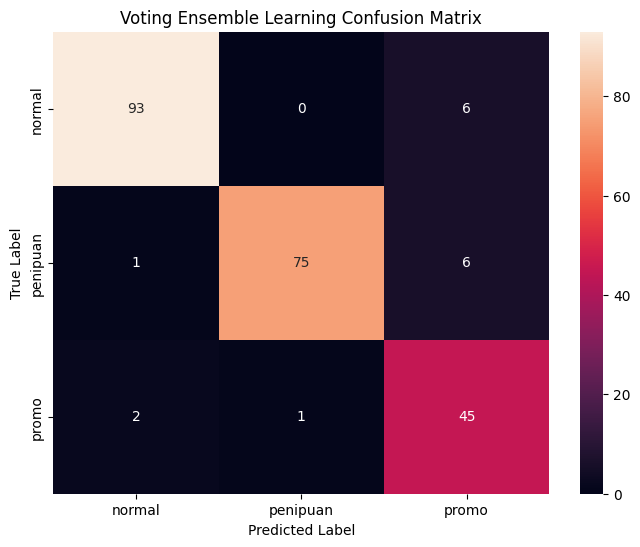

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Voting Ensemble Learning Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, InputLayer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import numpy as np

# Assuming you have already preprocessed your data and have features X and labels y
# X should be sequences padded to the same length

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom classifier class that inherits from scikit-learn's BaseEstimator and ClassifierMixin
class HybridCNNLSTMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = Sequential([
            InputLayer(input_shape=(X.shape[1], 1)),
            Conv1D(128, 5, activation='relu'),
            MaxPooling1D(pool_size=4),
            LSTM(64),
            Dense(3, activation='softmax')
        ])
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    def fit(self, X, y):
        # X is expected to be sequences with shape (num_samples, sequence_length, embedding_dim)
        self.model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

# Instantiate the Hybrid CNN-LSTM classifier
hybrid_cnn_lstm_classifier = HybridCNNLSTMClassifier()

# Instantiate the other classifiers
naive_bayes_classifier = GaussianNB(var_smoothing = 1e-6)
svm_classifier = SVC(kernel='rbf', C = 10)

# Voting Ensemble
stacking_classifier = StackingClassifier(
    estimators=[
        ('hybrid_cnn_lstm', hybrid_cnn_lstm_classifier),
        ('naive_bayes', naive_bayes_classifier),
        ('svm', svm_classifier)
    ],
    stack_method='auto'  # Use 'hard' voting for simple majority voting
)

# param_grid = {
#     'hybrid_cnn_lstm__model__epochs': [5, 10],
#     'hybrid_cnn_lstm__model__optimizer__lr': [0.001, 0.01, 0.1],
#     'hybrid_cnn_lstm__model__conv_units': [64, 128, 256],
#     'hybrid_cnn_lstm__model__lstm_units': [64, 128, 256],
#     'hybrid_cnn_lstm__model__conv_kernel_size': [3, 5, 7],
#     'hybrid_cnn_lstm__model__pool_size': [2, 3, 4],
#     'hybrid_cnn_lstm__model__dropout_rate': [0.2, 0.3, 0.4],

# }

# # Use GridSearchCV to search for the best parameters
# grid_search = GridSearchCV(estimator=voting_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# # Fit GridSearchCV
# grid_search.fit(X_train, y_train)

# # Get the best parameters and the best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print("Best Parameters:", best_params)
# print("Best Cross-Validation Score:", best_score)

# best_estimator = grid_search.best_estimator_
# test_predictions = best_estimator.predict(X_test)
# Train the ensemble classifier
stacking_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = stacking_classifier.predict(X_test)
prediction = stacking_classifier.predict(X_train)
# Evaluate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

accuracys = accuracy_score(y_train, prediction)
precisions = precision_score(y_train, prediction, average='weighted')
recalls = recall_score(y_train, prediction, average='weighted')
f1s = f1_score(y_train, prediction, average='weighted')

print("stack Ensemble Accuracy:", accuracy)
print("stack Ensemble Precision:", precision)
print("stack Ensemble Recall:", recall)
print("stack Ensemble F1-Score:", f1)

print("stack Ensemble Accuracy:", accuracys)
print("stack Ensemble Precision:", precisions)
print("stack Ensemble Recall:", recalls)
print("stack Ensemble F1-Score:", f1s)

Epoch 1/5
12/12 [==============================] - 3s 63ms/step - loss: 1.0215 - accuracy: 0.4802 - val_loss: 0.9690 - val_accuracy: 0.5191
Epoch 2/5
12/12 [==============================] - 0s 16ms/step - loss: 0.9630 - accuracy: 0.5130 - val_loss: 0.9416 - val_accuracy: 0.5191
Epoch 3/5
12/12 [==============================] - 0s 15ms/step - loss: 0.9116 - accuracy: 0.5130 - val_loss: 0.8636 - val_accuracy: 0.5191
Epoch 4/5
12/12 [==============================] - 0s 15ms/step - loss: 0.7873 - accuracy: 0.6183 - val_loss: 0.7498 - val_accuracy: 0.7213
Epoch 5/5
12/12 [==============================] - 0s 14ms/step - loss: 0.7291 - accuracy: 0.7127 - val_loss: 0.6957 - val_accuracy: 0.6831
Epoch 1/5
10/10 [==============================] - 3s 74ms/step - loss: 1.0396 - accuracy: 0.4760 - val_loss: 0.9867 - val_accuracy: 0.5102
Epoch 2/5
10/10 [==============================] - 0s 23ms/step - loss: 0.9751 - accuracy: 0.5154 - val_loss: 0.9583 - val_accuracy: 0.5102
Epoch 3/5
10/10 [===

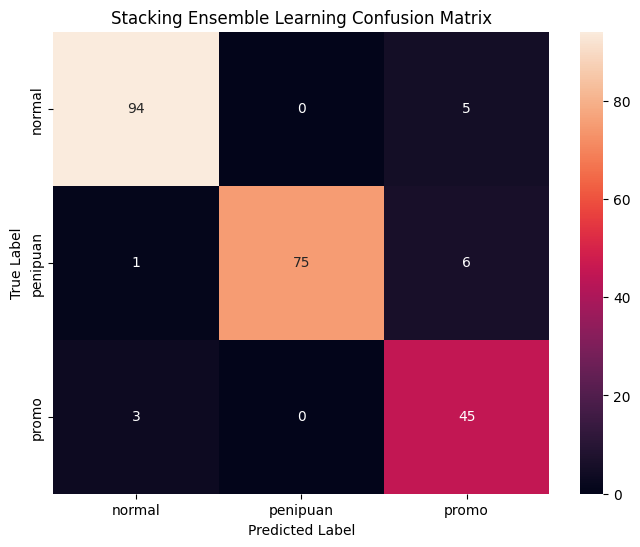

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Stacking Ensemble Learning Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**ENSEMBLE WITH STACKING**

Epoch 1/5
12/12 [==============================] - 3s 64ms/step - loss: 1.0067 - accuracy: 0.5116 - val_loss: 0.9654 - val_accuracy: 0.5191
Epoch 2/5
12/12 [==============================] - 0s 17ms/step - loss: 0.9524 - accuracy: 0.5130 - val_loss: 0.9250 - val_accuracy: 0.5191
Epoch 3/5
12/12 [==============================] - 0s 15ms/step - loss: 0.8735 - accuracy: 0.5417 - val_loss: 0.7461 - val_accuracy: 0.6831
Epoch 4/5
12/12 [==============================] - 0s 14ms/step - loss: 0.7197 - accuracy: 0.6840 - val_loss: 0.6406 - val_accuracy: 0.7104
Epoch 5/5
29/29 [==============================] - 0s 6ms/step
Stacking Ensemble Accuracy: 0.9432314410480349
Stacking Ensemble Precision: 0.9464273804510172
Stacking Ensemble Recall: 0.9432314410480349
Stacking Ensemble F1-Score: 0.9442181333712468
Stacking Ensemble Accuracy: 1.0
Stacking Ensemble Precision: 1.0
Stacking Ensemble Recall: 1.0
Stacking Ensemble F1-Score: 1.0


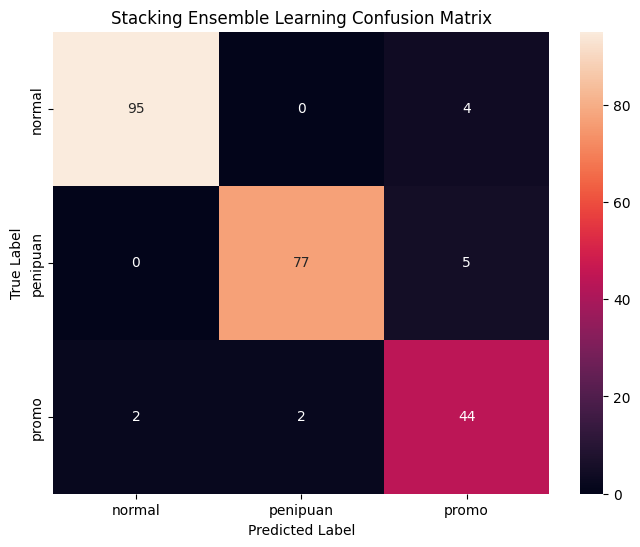

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, InputLayer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your X data is already in the correct format as shown
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom classifier class for the Hybrid CNN-LSTM model
class HybridCNNLSTMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = Sequential([
            InputLayer(input_shape=(X.shape[1], 1)),
            Conv1D(128, 5, activation='relu'),
            MaxPooling1D(pool_size=4),
            LSTM(64),
            Dense(3, activation='softmax')
        ])
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    def fit(self, X, y):
        X = np.expand_dims(X, axis=-1)
        self.model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

    def predict(self, X):
        X = np.expand_dims(X, axis=-1)
        return np.argmax(self.model.predict(X), axis=1)

# Instantiate the base classifiers
hybrid_cnn_lstm_classifier = HybridCNNLSTMClassifier()
naive_bayes_classifier = GaussianNB()
svm_classifier = SVC(kernel='linear', probability=True)

# Train the base classifiers
hybrid_cnn_lstm_classifier.fit(X_train, y_train)
nb_predictions = naive_bayes_classifier.fit(X_train, y_train).predict(X_train)
svm_predictions = svm_classifier.fit(X_train, y_train).predict(X_train)
cnn_lstm_predictions = hybrid_cnn_lstm_classifier.predict(X_train)

# Create meta-features from the base classifiers' predictions
meta_features = np.column_stack((cnn_lstm_predictions, nb_predictions, svm_predictions))

# Train the meta-model
meta_model = LogisticRegression()
meta_model.fit(meta_features, y_train)

# Predict using base models on test set
cnn_lstm_test_predictions = hybrid_cnn_lstm_classifier.predict(X_test)
nb_test_predictions = naive_bayes_classifier.predict(X_test)
svm_test_predictions = svm_classifier.predict(X_test)

cnn_lstm_train_predictions = hybrid_cnn_lstm_classifier.predict(X_train)
nb_train_predictions = naive_bayes_classifier.predict(X_train)
svm_train_predictions = svm_classifier.predict(X_train)
# Create meta-features for the test set
meta_test_features = np.column_stack((cnn_lstm_test_predictions, nb_test_predictions, svm_test_predictions))
meta_train_features = np.column_stack((cnn_lstm_train_predictions, nb_train_predictions, svm_train_predictions))

# Predict using the meta-model
final_predictions = meta_model.predict(meta_test_features)
prediction = meta_model.predict(meta_train_features)
# Evaluate metrics
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions, average='weighted')
recall = recall_score(y_test, final_predictions, average='weighted')
f1 = f1_score(y_test, final_predictions, average='weighted')

accuracys = accuracy_score(y_train, prediction)
precisions = precision_score(y_train, prediction, average='weighted')
recalls = recall_score(y_train, prediction, average='weighted')
f1s = f1_score(y_train, prediction, average='weighted')

print("Stacking Ensemble Accuracy:", accuracy)
print("Stacking Ensemble Precision:", precision)
print("Stacking Ensemble Recall:", recall)
print("Stacking Ensemble F1-Score:", f1)

print("Stacking Ensemble Accuracy:", accuracys)
print("Stacking Ensemble Precision:", precisions)
print("Stacking Ensemble Recall:", recalls)
print("Stacking Ensemble F1-Score:", f1s)

# Calculate confusion matrix
cm = confusion_matrix(y_test, final_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Stacking Ensemble Learning Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Bagging Ensemble Learning

Epoch 1/5
12/12 [==============================] - 3s 60ms/step - loss: 0.9680 - accuracy: 0.5335 - val_loss: 1.0113 - val_accuracy: 0.4536
Epoch 2/5
12/12 [==============================] - 0s 16ms/step - loss: 0.8964 - accuracy: 0.5404 - val_loss: 0.8905 - val_accuracy: 0.5738
Epoch 3/5
12/12 [==============================] - 0s 14ms/step - loss: 0.7963 - accuracy: 0.6375 - val_loss: 0.7793 - val_accuracy: 0.6940
Epoch 4/5
12/12 [==============================] - 0s 15ms/step - loss: 0.7559 - accuracy: 0.6211 - val_loss: 0.8035 - val_accuracy: 0.6885
Epoch 5/5
8/8 [==============================] - 0s 5ms/step
Epoch 1/5
12/12 [==============================] - 0s 19ms/step - loss: 0.6176 - accuracy: 0.7196 - val_loss: 0.6819 - val_accuracy: 0.6831
Epoch 2/5
12/12 [==============================] - 0s 15ms/step - loss: 0.5710 - accuracy: 0.7373 - val_loss: 0.5730 - val_accuracy: 0.7377
Epoch 3/5
12/12 [==============================] - 0s 15ms/step - loss: 0.5068 - accuracy: 0.7633 -

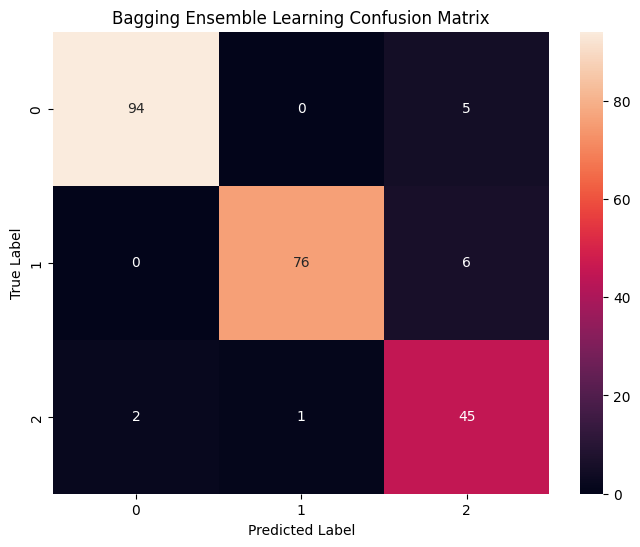

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, InputLayer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.utils import resample
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom classifier class for the Hybrid CNN-LSTM model
class HybridCNNLSTMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = Sequential([
            InputLayer(input_shape=(X.shape[1], 1)),
            Conv1D(128, 5, activation='relu'),
            MaxPooling1D(pool_size=4),
            LSTM(64),
            Dense(3, activation='softmax')
        ])
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    def fit(self, X, y):
        X = np.expand_dims(X, axis=-1)  # Expand dimensions for Conv1D layer
        self.model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

    def predict(self, X):
        X = np.expand_dims(X, axis=-1)  # Expand dimensions for Conv1D layer
        return np.argmax(self.model.predict(X), axis=1)

    def predict_proba(self, X):
        X = np.expand_dims(X, axis=-1)  # Expand dimensions for Conv1D layer
        return self.model.predict(X)

# Function to train and predict using bagging
def bagging_ensemble_predict(X_train, y_train, X_test, base_models, n_estimators=10):
    predictions = np.zeros((X_test.shape[0], len(base_models) * n_estimators))

    for i, model in enumerate(base_models):
        for n in range(n_estimators):
            # Bootstrap sampling
            X_resampled, y_resampled = resample(X_train, y_train, random_state=n)

            # Train model on resampled data
            model.fit(X_resampled, y_resampled)

            # Predict on test set
            start_idx = i * n_estimators + n
            if hasattr(model, "predict_proba"):
                predictions[:, start_idx] = np.argmax(model.predict_proba(X_test), axis=1)
            else:
                predictions[:, start_idx] = model.predict(X_test)

    # Aggregate predictions by majority voting
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=1, arr=predictions)
    return final_predictions

# Instantiate the classifiers
hybrid_cnn_lstm_classifier = HybridCNNLSTMClassifier()
naive_bayes_classifier = GaussianNB()
svm_classifier = SVC(kernel='linear', probability=True)

# Combine them into a list
base_models = [hybrid_cnn_lstm_classifier, naive_bayes_classifier, svm_classifier]

# Assuming your X data is already in the correct format
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run bagging ensemble prediction
final_predictions = bagging_ensemble_predict(X_train, y_train, X_test, base_models, n_estimators=10)

# Evaluate metrics
accuracy = accuracy_score(y_test, final_predictions)
precision = precision_score(y_test, final_predictions, average='weighted')
recall = recall_score(y_test, final_predictions, average='weighted')
f1 = f1_score(y_test, final_predictions, average='weighted')

print("Bagging Ensemble Accuracy:", accuracy)
print("Bagging Ensemble Precision:", precision)
print("Bagging Ensemble Recall:", recall)
print("Bagging Ensemble F1-Score:", f1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, final_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Bagging Ensemble Learning Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
svmPredictions = svm_classifier.predict(X_test)
svmPrediction = svm_classifier.predict(X_train)
# Evaluate accuracy
accuracy = accuracy_score(y_test, svmPredictions)
print("svm Accuracy:", accuracy)
precision = precision_score(y_test, svmPredictions, average='weighted')
print("svm Precision:", precision)
recall = recall_score(y_test, svmPredictions, average='weighted')
print("svm Recall:", recall)
f1 = f1_score(y_test, svmPredictions, average='weighted')
print("svm F1-Score:", f1)

accuracy = accuracy_score(y_train, svmPrediction)
print("svm Accuracy:", accuracy)
precision = precision_score(y_train, svmPrediction, average='weighted')
print("svm Precision:", precision)
recall = recall_score(y_train, svmPrediction, average='weighted')
print("svm Recall:", recall)
f1 = f1_score(y_train, svmPrediction, average='weighted')
print("svm F1-Score:", f1)

svm Accuracy: 0.9432314410480349
svm Precision: 0.9465814947929851
svm Recall: 0.9432314410480349
svm F1-Score: 0.9442315095229515
svm Accuracy: 1.0
svm Precision: 1.0
svm Recall: 1.0
svm F1-Score: 1.0


In [ ]:
naive_bayes_classifier.fit(X_train, y_train)

# Make predictions on the test set
naive_bayesPredictions = naive_bayes_classifier.predict(X_test)
naive_bayesPrediction = naive_bayes_classifier.predict(X_train)
# Evaluate accuracy
accuracy = accuracy_score(y_test, naive_bayesPredictions)
print("naive_bayes Accuracy:", accuracy)
precision = precision_score(y_test, naive_bayesPredictions, average='weighted')
print("naive_bayes Precision:", precision)
recall = recall_score(y_test, naive_bayesPredictions, average='weighted')
print("naive_bayes Recall:", recall)
f1 = f1_score(y_test, naive_bayesPredictions, average='weighted')
print("naive_bayes F1-Score:", f1)

accuracy = accuracy_score(y_train, naive_bayesPrediction)
print("naive_bayes Accuracy:", accuracy)
precision = precision_score(y_train, naive_bayesPrediction, average='weighted')
print("naive_bayes Precision:", precision)
recall = recall_score(y_train, naive_bayesPrediction, average='weighted')
print("naive_bayes Recall:", recall)
f1 = f1_score(y_train, naive_bayesPrediction, average='weighted')
print("naive_bayes F1-Score:", f1)

naive_bayes Accuracy: 0.9388646288209607
naive_bayes Precision: 0.9451350916761169
naive_bayes Recall: 0.9388646288209607
naive_bayes F1-Score: 0.9405283288718665
naive_bayes Accuracy: 0.949671772428884
naive_bayes Precision: 0.9501311279520901
naive_bayes Recall: 0.949671772428884
naive_bayes F1-Score: 0.9497947539174316


In [ ]:
hybrid_cnn_lstm_classifier.fit(X_train, y_train)

# Make predictions on the test set
hybrid_cnn_lstmPredictions = hybrid_cnn_lstm_classifier.predict(X_test)
hybrid_cnn_lstmPrediction = hybrid_cnn_lstm_classifier.predict(X_train)
# Evaluate accuracy
accuracy = accuracy_score(y_test, hybrid_cnn_lstmPredictions)
print("hybrid_cnn_lstm Accuracy:", accuracy)
precision = precision_score(y_test, hybrid_cnn_lstmPredictions, average='weighted')
print("hybrid_cnn_lstm Precision:", precision)
recall = recall_score(y_test, hybrid_cnn_lstmPredictions, average='weighted')
print("hybrid_cnn_lstm Recall:", recall)
f1 = f1_score(y_test, hybrid_cnn_lstmPredictions, average='weighted')
print("hybrid_cnn_lstm F1-Score:", f1)

accuracy = accuracy_score(y_train, hybrid_cnn_lstmPrediction)
print("hybrid_cnn_lstm Accuracy:", accuracy)
precision = precision_score(y_train, hybrid_cnn_lstmPrediction, average='weighted')
print("hybrid_cnn_lstm Precision:", precision)
recall = recall_score(y_train, hybrid_cnn_lstmPrediction, average='weighted')
print("hybrid_cnn_lstm Recall:", recall)
f1 = f1_score(y_train, hybrid_cnn_lstmPrediction, average='weighted')
print("hybrid_cnn_lstm F1-Score:", f1)

Epoch 1/5
12/12 [==============================] - 0s 30ms/step - loss: 0.1423 - accuracy: 0.9494 - val_loss: 0.1811 - val_accuracy: 0.9235
Epoch 2/5
12/12 [==============================] - 0s 20ms/step - loss: 0.1273 - accuracy: 0.9617 - val_loss: 0.1401 - val_accuracy: 0.9508
Epoch 3/5
12/12 [==============================] - 0s 19ms/step - loss: 0.1043 - accuracy: 0.9644 - val_loss: 0.1715 - val_accuracy: 0.9399
Epoch 4/5
12/12 [==============================] - 0s 21ms/step - loss: 0.1118 - accuracy: 0.9603 - val_loss: 0.1529 - val_accuracy: 0.9508
Epoch 5/5
29/29 [==============================] - 0s 6ms/step
hybrid_cnn_lstm Accuracy: 0.8646288209606987
hybrid_cnn_lstm Precision: 0.8806605611676984
hybrid_cnn_lstm Recall: 0.8646288209606987
hybrid_cnn_lstm F1-Score: 0.8669702806346345
hybrid_cnn_lstm Accuracy: 0.9704595185995624
hybrid_cnn_lstm Precision: 0.970434357786758
hybrid_cnn_lstm Recall: 0.9704595185995624
hybrid_cnn_lstm F1-Score: 0.9704449925956137
